# Start

In [1]:
###### dataset metadata
#!pip install seaborn
from pipelines import train_mini, train, test

from pipelines import ScriptDataset, transform_pipeline, test_transform_pipeline, minimal_preprocessing_pipeline, convert_to_script

from torch.utils.data import DataLoader
import torchvision.models as models
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.multiprocessing as mp

from PIL import Image 

import random
import time
import math
import os
from IPython.display import clear_output

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
            classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

import gc # garbage collection
import pickle
import pandas as pd

import csv

from scipy.interpolate import make_interp_spline


loading image metadata... done


In [2]:
with open('val.csv', mode='r', encoding='utf-8') as file:
    reader = csv.DictReader(file)  # Reads the CSV into a list of dictionaries
    val = [{**row, 'label_num': int(row['label_num'])} for row in reader]  # Convert label_num to int

In [3]:
def plot_smoothed_loss(csv_filename):
    """
    Reads a CSV file containing loss values, applies smoothing, and plots the loss curve.
    
    Parameters:
        csv_filename (str): Name of the CSV file containing loss values.
    
    Output:
        A smoothed loss plot with y-grid lines at every 0.5 interval.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Load dataset
    loss_df = pd.read_csv(csv_filename)

    # Ensure the index represents the batch number
    loss_df.index.name = "batch"


    # Apply moving average smoothing to the 'loss' column
    window_size = 20  # Adjust for more or less smoothing
    loss_df["smoothed_loss"] = loss_df["loss"].rolling(window=window_size, min_periods=1).mean()

    # Define colors for k-values

    plt.figure(figsize=(10, 5))

    # Loop through each k-value and plot separately with smoothed loss
    for k_value, color in colors.items():
        subset = loss_df[loss_df["k"] == k_value]
        plt.plot(subset.index, subset["smoothed_loss"], color="red", alpha=0.9, linewidth=2)

    plt.xlabel("Batch Number")
    plt.ylabel("Smoothed Loss")
    plt.title(f"Training Loss Over Batches ({csv_filename.replace('.csv', '').replace('loss_','')}) - Smoothed")
    plt.ylim(bottom=0, top=3.0)

    # Add grid lines at every 0.5 interval
    y_ticks = np.arange(0, loss_df["smoothed_loss"].max() + 0.5, 0.5)
    plt.yticks(y_ticks)
    plt.grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
    plt.legend()
    plt.show()

In [4]:
num_classes = 12

model_rn50 = models.resnet50(weights="DEFAULT") #  weights='DEFAULT' and weights='IMAGENET1K_V1' are the same
model_rn50.fc = torch.nn.Linear(2048, num_classes)  # Adjust output layer for your number of classes
model_rn50.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=2, padding=5, bias=False)


model_resnext = models.resnext101_64x4d(weights="DEFAULT") 
model_resnext.fc = torch.nn.Linear(2048, num_classes)  
model_resnext.conv1 = nn.Conv2d(3, 64, kernel_size=(11, 11), stride=2, padding=5, bias=False)



model_efficientnet = models.efficientnet_b0(weights="DEFAULT") 
model_efficientnet.classifier[1] = torch.nn.Linear(1280, num_classes) 
model_efficientnet.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(7, 7), stride=(2, 2), padding=3, bias=False
)


model_convnext = models.convnext_tiny(weights="DEFAULT") 
model_convnext.classifier[2] = torch.nn.Linear(768, num_classes)  
model_convnext.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=96, kernel_size=(8, 8), stride=(4, 4), padding=3, bias=False
)



model_efficientnet_noBLF_noGeo = models.efficientnet_b0(weights="DEFAULT") 
model_efficientnet_noBLF_noGeo.classifier[1] = torch.nn.Linear(1280, num_classes) 
model_efficientnet_noBLF_noGeo.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=32, kernel_size=(7, 7), stride=(2, 2), padding=3, bias=False
)


model_convnext_noBLF_noGeo = models.convnext_tiny(weights="DEFAULT") 
model_convnext_noBLF_noGeo.classifier[2] = torch.nn.Linear(768, num_classes)  
model_convnext_noBLF_noGeo.features[0][0] = nn.Conv2d(
    in_channels=3, out_channels=96, kernel_size=(8, 8), stride=(4, 4), padding=3, bias=False
)


model_definitions = {
    "resnet50.pkl": model_rn50,
    "resnext101.pkl": model_resnext,
    "efficientnet_b0.pkl": model_efficientnet,
    "convnext_tiny.pkl": model_convnext,
    "efficientnet_b0_noBLF_noGeo.pkl": model_efficientnet_noBLF_noGeo,
    "model_convnext_noBLF_noGeo.pkl": model_convnext_noBLF_noGeo
}

In [6]:
model_paths = ["resnet50.pkl", "resnext101.pkl", "efficientnet_b0.pkl", "convnext_tiny.pkl", "efficientnet_b0_noBLF_noGeo.pkl",
    "model_convnext_noBLF_noGeo.pkl"]

# Load each model
models_loaded = {}

for path in model_paths:
    with open("pickle/"+path, "rb") as file:
        state_dict = pickle.load(file)  # Load saved weights (state dict)
    # Retrieve the correct model definition
    model = model_definitions[path]
    # Load state dictionary
    model.load_state_dict(state_dict)
    # Set to evaluation mode
    model.eval()
    models_loaded[path] = model

print(f"Loaded {len(models_loaded)} models successfully!")

Loaded 6 models successfully!


In [7]:

script_dataset = ScriptDataset(val, transform=test_transform_pipeline, multiplier=50, max_size=None)
# batches =  math.ceil(len(script_dataset) /sample_labels.shape[0])
data_loader = DataLoader(script_dataset, batch_size=50, shuffle=True, pin_memory=True, num_workers = 2
                        , prefetch_factor=2 * 3, persistent_workers=True)



In [10]:
def run_inference_for_model(model, model_name, test_loader, num_runs=15, num_classes=12, device=None):
    """
    Runs inference for a single model, accumulating probabilities over multiple votes.

    Parameters:
    - model: The PyTorch model to evaluate.
    - model_name: The string name of the model.
    - test_loader: PyTorch DataLoader for test images.
    - num_runs: Number of voting passes per image.
    - num_classes: Number of output classes.
    - device: CUDA or CPU device.

    Returns:
    - A NumPy array of shape (num_samples, num_classes), storing accumulated probabilities.
    - The corresponding true labels for each sample.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Enable multi-GPU if available
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs for {model_name}!")
        model = torch.nn.DataParallel(model)

    # Move model to correct device
    model.to(device)
    model.eval()

    print(f"\nRunning inference for {model_name} with {num_runs} votes per image...")

    # Allocate space for accumulated probabilities
    all_probs = []
    all_labels = []

    # Start inference
    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # Initialize tensor to store summed probabilities
            sum_probs = torch.zeros(images.size(0), num_classes, device=device)

            # Run multiple passes for each image
            for _ in range(num_runs):
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
                sum_probs += probs  # Accumulate probabilities

            # Move results to CPU for storage
            all_probs.append(sum_probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Print progress
            print(f"Processing batch {batch_idx}/{len(test_loader)}... ({batch_idx / len(test_loader):.2%} complete)")

    # Convert lists to NumPy arrays
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.array(all_labels)

    # Calculate time taken
    total_time = time.time() - start_time
    total_time_minutes = total_time / 60
    print(f"✅ {model_name} Completed | Total Time: {total_time_minutes:.2f} min")

    del model
    torch.cuda.empty_cache()  # Free GPU memory
    gc.collect()  # Force Python garbage collection

    return all_probs, all_labels

In [11]:
# Test single output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a single test dataset and DataLoader
val_dataset = ScriptDataset(val, transform=minimal_preprocessing_pipeline, multiplier=1)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

image, label = val_dataset[0]  # or use a specific index
image = image.unsqueeze(0).to(device)  # shape: [1, C, H, W]
label = torch.tensor([label]).to(device)

model_rn50.eval()
model_rn50.to(device)
with torch.no_grad():
    output = model_rn50(image)  # raw logits

print(output)

tensor([[ 0.1941, -0.0747, -0.1124,  0.2281, -0.0118,  0.0285,  0.0204,  0.2450,
         -0.1346,  0.4036, -0.2010, -0.2277]], device='cuda:0')


In [14]:


# Dictionary to store model outputs
model_outputs = {}

# Run inference for each model
for model_name, model in models_loaded.items():
    model_probs, model_labels = run_inference_for_model(model, model_name, val_loader, device=device)
    model_outputs[model_name] = {
        "probs": model_probs,
        "labels": model_labels
    }

print("\n✅ All models processed successfully!")


Using 3 GPUs for model_convnext_noBLF_noGeo.pkl!

Running inference for model_convnext_noBLF_noGeo.pkl with 15 votes per image...
Processing batch 1/9... (11.11% complete)
Processing batch 2/9... (22.22% complete)
Processing batch 3/9... (33.33% complete)
Processing batch 4/9... (44.44% complete)
Processing batch 5/9... (55.56% complete)
Processing batch 6/9... (66.67% complete)
Processing batch 7/9... (77.78% complete)
Processing batch 8/9... (88.89% complete)
Processing batch 9/9... (100.00% complete)
✅ model_convnext_noBLF_noGeo.pkl Completed | Total Time: 1.31 min

✅ All models processed successfully!


In [16]:
output_path = "pickle/model_outputs_val.pkl"

# Save model_outputs dictionary
with open(output_path, "wb") as f:
    pickle.dump(model_outputs, f)

In [8]:
with open("pickle/model_outputs_val.pkl", "rb") as f:
    model_outputs = pickle.load(f)

In [9]:
for key, value in model_outputs.items():
    print(key)


resnet50.pkl
resnext101.pkl
efficientnet_b0.pkl
convnext_tiny.pkl
efficientnet_b0_noBLF_noGeo.pkl
model_convnext_noBLF_noGeo.pkl


In [14]:
model_outputs['resnet50.pkl']

{'probs': array([[3.76592904e-01, 1.14773631e+00, 2.80792378e-02, ...,
         2.52627283e-02, 4.67893171e+00, 2.37065703e-01],
        [1.09878260e-06, 3.56495002e-05, 5.19744333e-07, ...,
         3.30468129e-06, 2.93560268e-04, 5.20957201e-07],
        [1.34139175e+01, 1.06144641e-02, 1.56149614e+00, ...,
         1.88711692e-05, 1.07562708e-04, 5.21208346e-03],
        ...,
        [6.48848072e-04, 1.47063169e+01, 1.90589140e-04, ...,
         3.05610156e-05, 1.35500878e-02, 2.51153309e-04],
        [9.86164821e-08, 2.29269044e-05, 1.17195720e-08, ...,
         1.33201902e-05, 1.24930695e-01, 6.61806654e-09],
        [2.79010117e-01, 4.86936903e+00, 6.83473609e-03, ...,
         4.87789363e-02, 1.09930861e+00, 2.92436443e-02]],
       shape=(1280, 12), dtype=float32),
 'labels': array([5, 5, 0, ..., 1, 8, 1], shape=(1280,))}

In [16]:
def moving_average(values, window=3):
    return np.convolve(values, np.ones(window)/window, mode='valid')

def plot_loss_per_batch_by_model(
    model_outputs,
    criterion,
    batch_size=200,
    k=15,
    title="Neural Network Tuning Loss in Eval Mode",
    smoothing='moving_average',  # 'moving_average', 'spline', or None
    window=3                     # Used only if smoothing is moving_average
):
    """
    Plots validation loss per batch for each model with optional smoothing.

    Parameters:
    - model_outputs: dict with model_name → {"probs": logits [N, C], "labels": [N]}
    - criterion: a loss function (e.g. CrossEntropyLoss)
    - batch_size: batch size used during inference
    - k: number of voting passes (to average logits)
    - title: chart title
    - smoothing: 'moving_average', 'spline', or None
    - window: smoothing window for moving average
    """
    plt.figure(figsize=(10, 6))

    if (smoothing != 'none'):
        title += ' (smoothed)'
    
    for model_name, output in model_outputs.items():
        logits = torch.tensor(output["probs"]) / k
        labels = torch.tensor(output["labels"])

        batch_losses = []

        for i in range(0, len(labels), batch_size):
            batch_logits = logits[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            loss = criterion(batch_logits, batch_labels)
            batch_losses.append(loss.item())

        x = np.arange(len(batch_losses))

        if smoothing == 'moving_average':
            y = moving_average(batch_losses, window=window)
            x = np.arange(len(y))  # adjust x to match y
            plt.plot(x, y, label=f"{model_name}", linewidth=2)
        elif smoothing == 'spline':
            if len(batch_losses) >= 4:
                x_smooth = np.linspace(x.min(), x.max(), 300)
                spline = make_interp_spline(x, batch_losses, k=3)
                y_smooth = spline(x_smooth)
                plt.plot(x_smooth, y_smooth, label=f"{model_name} (Spline)", linewidth=2)
            else:
                plt.plot(x, batch_losses, label=model_name, linestyle='--', linewidth=2)
        else:
            plt.plot(x, batch_losses, label=model_name, linewidth=2)

    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.ylim(bottom=0,top=2.5)
    plt.show()

    


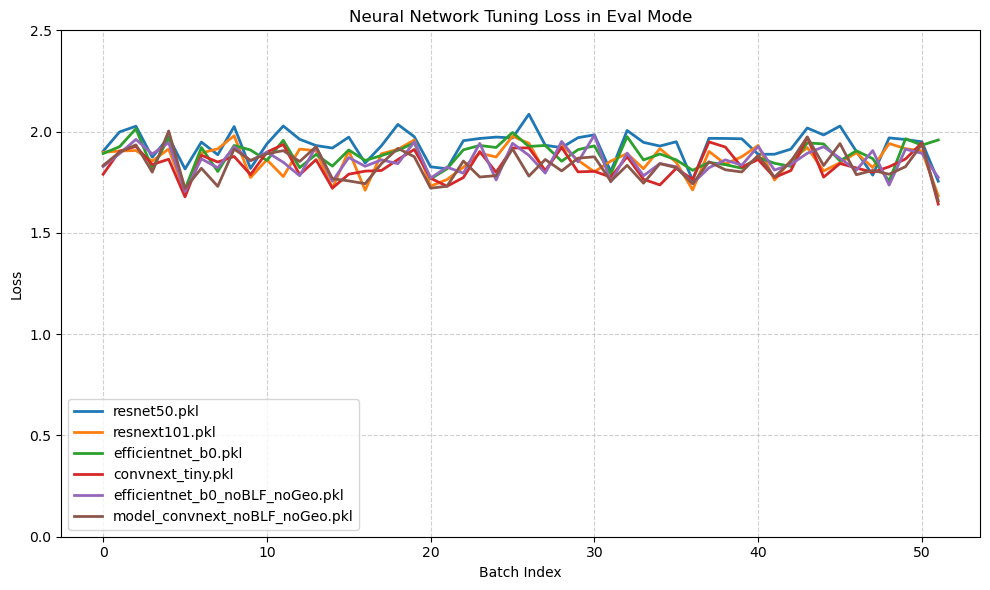

In [17]:
criterion = torch.nn.CrossEntropyLoss()
plot_loss_per_batch_by_model(model_outputs, criterion, batch_size=25, k=15, smoothing='none')


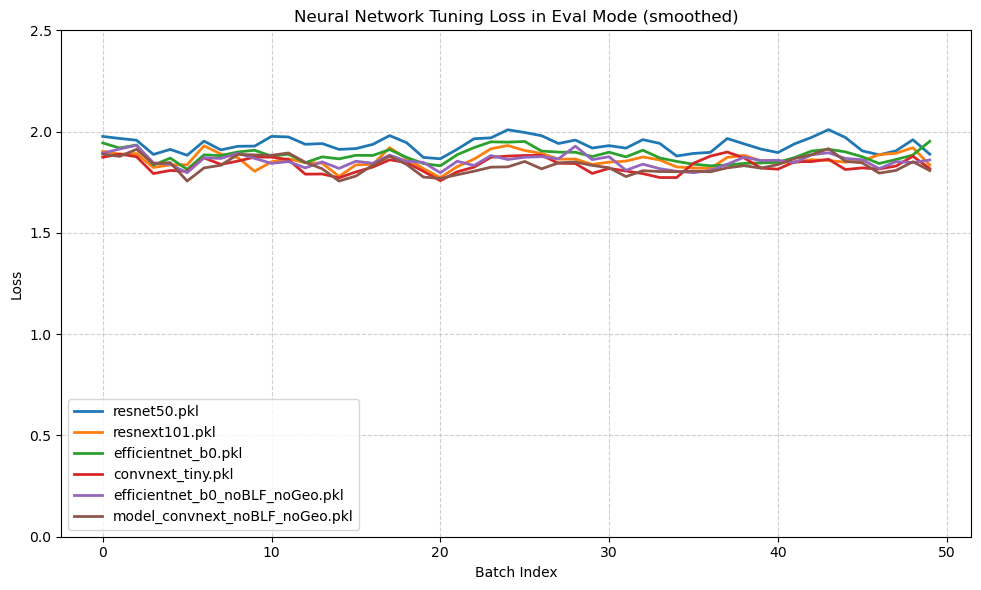

In [18]:
criterion = torch.nn.CrossEntropyLoss()
plot_loss_per_batch_by_model(model_outputs, criterion, batch_size=25, k=15)


In [21]:
for model_name, data in model_outputs.items():
    df = pd.DataFrame(data["probs"], columns=[f"Class_{i}" for i in range(12)])
    df["True_Label"] = data["labels"]

    # Save to CSV
    filename = f"probs/{model_name}_probabilities.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")

✅ Saved probs/resnet50.pkl_probabilities.csv
✅ Saved probs/resnext101.pkl_probabilities.csv
✅ Saved probs/efficientnet_b0.pkl_probabilities.csv
✅ Saved probs/convnext_tiny.pkl_probabilities.csv
✅ Saved probs/efficientnet_b0_noBLF_noGeo.pkl_probabilities.csv
✅ Saved probs/model_convnext_noBLF_noGeo.pkl_probabilities.csv


In [23]:
len(val)

1280

In [21]:
def train_linear_model(probs_folder="probs/"):
    """
    Loads probability outputs from deep models and trains a linear classifier.
    Returns the trained model and scaler.
    
    Parameters:
    - probs_folder (str): Directory containing probability CSV files.
    
    Returns:
    - trained linear model
    - trained feature scaler
    """
    import os
    import pandas as pd
    import numpy as np

    # Load all probability CSV files
    dataframes = []
    for filename in os.listdir(probs_folder):
        if filename.endswith("_probabilities.csv"):
            df = pd.read_csv(os.path.join(probs_folder, filename))
            df["Model"] = filename  # Track source model
            dataframes.append(df)

    # Combine all model outputs into a single dataset
    full_df = pd.concat(dataframes, ignore_index=True)

    # Extract features (probabilities) and target labels
    X = full_df.drop(columns=["True_Label", "Model"])  # Probabilities as features
    y = full_df["True_Label"].values  # True labels

    # Standardize feature values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train a Logistic Regression model on the full dataset
    linear_clf = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
    linear_clf.fit(X_scaled, y)

    print("✅ Linear model trained on full validation probabilities.")

    return linear_clf, scaler

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
linear_model, scaler = train_linear_model(probs_folder="probs/")

✅ Linear model trained on full validation probabilities.


/users/robl/.conda/envs/capstone2/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [19]:
def train_separate_linear_models(probs_folder="probs/", save_folder="pickle/"):
    """
    Loads probability outputs from each deep model, trains separate linear classifiers,
    and returns a dictionary of trained models and scalers.

    Parameters:
    - probs_folder (str): Directory containing probability CSV files.

    Returns:
    - models_dict: Dictionary of trained linear models {model_name: trained_model}
    - scalers_dict: Dictionary of trained scalers {model_name: scaler}
    """
    
    models_dict = {}
    scalers_dict = {}

    # Loop over all probability CSV files (one per deep model)
    for filename in os.listdir(probs_folder):
        if filename.endswith("_probabilities.csv"):
            model_name = filename.replace("_probabilities.csv", "")  # Extract model name
            file_path = os.path.join(probs_folder, filename)

            # Load the probability outputs
            df = pd.read_csv(file_path)
            X = df.drop(columns=["True_Label"])  # Probabilities as features
            y = df["True_Label"].values  # True labels

            # Standardize feature values
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            # Train a Logistic Regression model for this deep model
            linear_clf = LogisticRegression(max_iter=1000,  solver="lbfgs")
            linear_clf.fit(X_scaled, y)

            # Store the trained model and scaler
            models_dict[model_name] = linear_clf
            scalers_dict[model_name] = scaler

            # Save model and scaler
            model_path = os.path.join(save_folder, f"linear_{model_name}")
            scaler_path = os.path.join(save_folder, f"scaler_{model_name}")

            with open(model_path, "wb") as f:
                pickle.dump(linear_clf, f)

            with open(scaler_path, "wb") as f:
                pickle.dump(scaler, f)

            print(f"✅ Saved {model_name} linear model to {model_path}")
            print(f"✅ Saved {model_name} scaler to {scaler_path}")

            print(f"✅ Trained linear model for {model_name}")

    return models_dict, scalers_dict

In [22]:
linear_models, scalers = train_separate_linear_models(probs_folder="probs/")

✅ Saved resnext101.pkl linear model to pickle/linear_resnext101.pkl
✅ Saved resnext101.pkl scaler to pickle/scaler_resnext101.pkl
✅ Trained linear model for resnext101.pkl
✅ Saved efficientnet_b0.pkl linear model to pickle/linear_efficientnet_b0.pkl
✅ Saved efficientnet_b0.pkl scaler to pickle/scaler_efficientnet_b0.pkl
✅ Trained linear model for efficientnet_b0.pkl
✅ Saved convnext_tiny.pkl linear model to pickle/linear_convnext_tiny.pkl
✅ Saved convnext_tiny.pkl scaler to pickle/scaler_convnext_tiny.pkl
✅ Trained linear model for convnext_tiny.pkl
✅ Saved model_convnext_noBLF_noGeo.pkl linear model to pickle/linear_model_convnext_noBLF_noGeo.pkl
✅ Saved model_convnext_noBLF_noGeo.pkl scaler to pickle/scaler_model_convnext_noBLF_noGeo.pkl
✅ Trained linear model for model_convnext_noBLF_noGeo.pkl
✅ Saved efficientnet_b0_noBLF_noGeo.pkl linear model to pickle/linear_efficientnet_b0_noBLF_noGeo.pkl
✅ Saved efficientnet_b0_noBLF_noGeo.pkl scaler to pickle/scaler_efficientnet_b0_noBLF_noGe

# Test Tuned Models

In [23]:

scalers = {}
for model_name in models_loaded.keys():  # Use models_loaded keys instead of reloading
    scaler_path = f"pickle/scaler_{model_name}"
    with open(scaler_path, "rb") as f:
        scalers[model_name] = pickle.load(f)

# Load trained linear models
linear_models = {}
for model_name in models_loaded.keys():
    linear_model_path = f"pickle/linear_{model_name}"
    with open(linear_model_path, "rb") as f:
        linear_models[model_name] = pickle.load(f)

print("✅ Successfully loaded all scalers and linear models!")
print(scalers)
print(linear_models)

✅ Successfully loaded all scalers and linear models!
{'resnet50.pkl': StandardScaler(), 'resnext101.pkl': StandardScaler(), 'efficientnet_b0.pkl': StandardScaler(), 'convnext_tiny.pkl': StandardScaler(), 'efficientnet_b0_noBLF_noGeo.pkl': StandardScaler(), 'model_convnext_noBLF_noGeo.pkl': StandardScaler()}
{'resnet50.pkl': LogisticRegression(max_iter=1000), 'resnext101.pkl': LogisticRegression(max_iter=1000), 'efficientnet_b0.pkl': LogisticRegression(max_iter=1000), 'convnext_tiny.pkl': LogisticRegression(max_iter=1000), 'efficientnet_b0_noBLF_noGeo.pkl': LogisticRegression(max_iter=1000), 'model_convnext_noBLF_noGeo.pkl': LogisticRegression(max_iter=1000)}


In [24]:
def specificity_score(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    specificities = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fp + fn)

        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificities.append(spec)

    if average == 'macro':
        return np.mean(specificities)
    elif average == 'none':
        return specificities
    else:
        raise ValueError("Only 'macro' and 'none' are supported for specificity.")

# Score Tuned Model Outputs

## old code, don't delete

## new code, run this

In [25]:
def build_test_dict(deep_model, linear_model, scaler, test_loader, 
                    num_runs=15, num_classes=12, device=None):
    """
    Performs inference on the test data using the given deep model with multiple voting passes.
    
    Parameters:
    - deep_model: The deep model to evaluate.
    - test_loader: DataLoader for the test dataset.
    - num_runs (int): Number of inference passes (voting runs) per batch.
    - num_classes (int): Number of output classes.
    - device: Torch device to use (if None, automatically selects "cuda" if available).
    
    Returns:
    - test_dict (dict): Dictionary with the following keys:
         - "probs": Accumulated probability outputs (numpy array).
         - "preds": Final predictions from the probabilities (numpy array).
         - "labels": True labels (numpy array).
    """
    # Determine device if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to device and enable multi-GPU if available
    deep_model.to(device)
    if torch.cuda.device_count() > 1:
        deep_model = torch.nn.DataParallel(deep_model)
    deep_model.eval()
    
    all_torch_probs = []
    all_torch_preds = []
    all_linear_probs = []
    all_linear_preds = []

    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            
            # Accumulate probabilities using multiple runs (voting)
            sum_probs = torch.zeros(images.size(0), num_classes, device=device)
            for _ in range(num_runs):
                outputs = deep_model(images)
                probs = torch.softmax(outputs, dim=1)
                sum_probs += probs
            
            # Deep model outputs (torch part)
            batch_torch_probs = sum_probs.cpu().numpy()
            batch_torch_preds = np.argmax(batch_torch_probs, axis=1)
            
            # Process probabilities for the linear classifier
            # Make sure the DataFrame columns match the scaler's expected features
            df_probs = pd.DataFrame(batch_torch_probs, columns=[f"Class_{i}" for i in range(num_classes)])
            X_scaled = scaler.transform(df_probs)
            batch_linear_preds = linear_model.predict(X_scaled)
            batch_linear_probs = linear_model.predict_proba(X_scaled)
            
            # Accumulate batch results
            all_torch_probs.append(batch_torch_probs)
            all_torch_preds.append(batch_torch_preds)
            all_linear_probs.append(batch_linear_probs)
            all_linear_preds.append(batch_linear_preds)
            # all_labels.append(labels.cpu().numpy())
            
            print(f"Processed batch {batch_idx}/{len(test_loader)}")
    
    # Concatenate all batch results into single numpy arrays
    torch_probs = np.concatenate(all_torch_probs, axis=0)
    torch_preds = np.concatenate(all_torch_preds, axis=0)
    linear_probs = np.concatenate(all_linear_probs, axis=0)
    linear_preds = np.concatenate(all_linear_preds, axis=0)
    # labels = np.concatenate(all_labels, axis=0)
    
    return {
        "torch_probs": torch_probs,
        "torch_preds": torch_preds,
        "linear_probs": linear_probs,
        "linear_preds": linear_preds
        # "labels": labels
    }
    

In [26]:
dataset = test#[:200]
true_labels = np.array([sample["label_num"]-1 for sample in dataset])


test_dataset = ScriptDataset(dataset, transform=minimal_preprocessing_pipeline, multiplier=1)
test_loader = DataLoader(test_dataset, batch_size=150, shuffle=False)

evaluation_results = {}
for model_name, deep_model in models_loaded.items():
    print(f"\nEvaluating model: {model_name}")
    test_dict = build_test_dict(
        deep_model=deep_model,
        linear_model=linear_models[model_name],
        scaler=scalers[model_name],
        test_loader=test_loader,
        num_runs=15,
        num_classes=12
    )
    evaluation_results[model_name] = test_dict
    evaluation_results[model_name]['labels'] = true_labels




Evaluating model: resnet50.pkl
Processed batch 0/11
Processed batch 1/11
Processed batch 2/11
Processed batch 3/11
Processed batch 4/11
Processed batch 5/11
Processed batch 6/11
Processed batch 7/11
Processed batch 8/11
Processed batch 9/11
Processed batch 10/11

Evaluating model: resnext101.pkl
Processed batch 0/11
Processed batch 1/11
Processed batch 2/11
Processed batch 3/11
Processed batch 4/11
Processed batch 5/11
Processed batch 6/11
Processed batch 7/11
Processed batch 8/11
Processed batch 9/11
Processed batch 10/11

Evaluating model: efficientnet_b0.pkl
Processed batch 0/11
Processed batch 1/11
Processed batch 2/11
Processed batch 3/11
Processed batch 4/11
Processed batch 5/11
Processed batch 6/11
Processed batch 7/11
Processed batch 8/11
Processed batch 9/11
Processed batch 10/11

Evaluating model: convnext_tiny.pkl
Processed batch 0/11
Processed batch 1/11
Processed batch 2/11
Processed batch 3/11
Processed batch 4/11
Processed batch 5/11
Processed batch 6/11
Processed batch

In [29]:
def topk_accuracy(y_true, probs, k=3):
    topk_preds = np.argsort(probs, axis=1)[:, -k:]
    # For each sample, check if the true label is in the top-k indices
    correct = np.array([true_label in topk for true_label, topk in zip(y_true, topk_preds)])
    return np.mean(correct)

def score_models(result_set, model_name):
    torch_preds = result_set['torch_preds']
    torch_probs = result_set['torch_probs']
    tuned_preds = result_set['linear_preds']
    tuned_probs = result_set['linear_probs']
    labels = result_set['labels']

    print('_'*50,'\n\n',model_name,'\n','_'*50,sep='')
    # print(torch_preds)
    # print(tuned_preds)
    # print(labels)

    torch_precision =   precision_score(  labels, torch_preds, average='macro')
    torch_recall =      recall_score(     labels, torch_preds, average='macro')
    torch_specificity = specificity_score(labels, torch_preds, average='macro')
    torch_accuracy =    accuracy_score(   labels, torch_preds)
    torch_f1 =          f1_score(         labels, torch_preds, average='macro')
    
    torch_top1_accuracy =     topk_accuracy(    labels, torch_probs, k=1)
    torch_top3_accuracy =     topk_accuracy(    labels, torch_probs, k=3)


    print(f'Torch Precision: {torch_precision}')
    print(f'Torch Recall: {torch_recall}')
    print(f'Torch Specificity: {torch_specificity}')
    print(f'Torch Accuracy: {torch_accuracy}')
    print(f'Torch F1: {torch_f1}')
    print(f'Torch Top-1 Accuracy: {torch_top1_accuracy}')
    print(f'Torch Top-3 Accuracy: {torch_top3_accuracy}')

    print(classification_report(labels, torch_preds, digits=4))

    conf_matrix = confusion_matrix(labels, torch_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)#, display_labels=script_labels)
    disp.plot(cmap=plt.cm.Blues, values_format = 'd')
    plt.title(f"Confusion Matrix for {model_name.replace('.pkl','')}")
    #plt.xticks(rotation = 75)
    legend_handles = [mpatches.Patch(color='none', label=f"{i}: {script_labels[i]}") for i in range(len(script_labels))]
    plt.legend(handles=legend_handles, title="Class Mapping", loc='upper left', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()



    print('\n\n')


    tuned_precision =   precision_score(  labels, tuned_preds, average='macro')
    tuned_recall =      recall_score(     labels, tuned_preds, average='macro')
    tuned_specificity = specificity_score(labels, tuned_preds, average='macro')
    tuned_accuracy =    accuracy_score(   labels, tuned_preds)
    tuned_f1 =          f1_score(         labels, tuned_preds, average='macro')

    tuned_top1_accuracy =     topk_accuracy(    labels, tuned_probs, k=1)
    tuned_top3_accuracy =     topk_accuracy(    labels, tuned_probs, k=3)
    

    
    print(f'Tuned Precision: {tuned_precision}')
    print(f'Tuned Recall: {tuned_recall}')
    print(f'Tuned Specificity: {tuned_specificity}')
    print(f'Tuned Accuracy: {tuned_accuracy}')
    print(f'Tuned F1: {tuned_f1}')
    print(f'Tuned Top-1 Accuracy: {tuned_top1_accuracy}')
    print(f'Tuned Top-3 Accuracy: {tuned_top3_accuracy}')


    print(classification_report(labels, tuned_preds, digits=4))

    conf_matrix = confusion_matrix(labels, tuned_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)#, display_labels=script_labels)
    disp.plot(cmap=plt.cm.Blues, values_format = 'd')
    plt.title(f"Confusion Matrix for {model_name.replace('.pkl','')} (tuned)")
    #plt.xticks(rotation = 75)
    legend_handles = [mpatches.Patch(color='none', label=f"{i}: {script_labels[i]}") for i in range(len(script_labels))]
    plt.legend(handles=legend_handles, title="Class Mapping", loc='upper left', bbox_to_anchor=(1.3, 1))
    plt.tight_layout()
    plt.show()


    print('\n\n\n')

    metrics = {
    "torch_precision": torch_precision,
    "torch_recall": torch_recall,
    "torch_specificity": torch_specificity,
    "torch_accuracy": torch_accuracy,
    "torch_f1": torch_f1,
    "torch_top1_accuracy": torch_top1_accuracy,
    "torch_top3_accuracy": torch_top3_accuracy,
    "tuned_precision": tuned_precision,
    "tuned_recall": tuned_recall,
    "tuned_specificity": tuned_specificity,
    "tuned_accuracy": tuned_accuracy,
    "tuned_f1": tuned_f1,
    "tuned_top1_accuracy": tuned_top1_accuracy,
    "tuned_top3_accuracy": tuned_top3_accuracy,
    }

    return metrics
    

__________________________________________________

resnet50.pkl
__________________________________________________
Torch Precision: 0.7798167851952248
Torch Recall: 0.6915393672807358
Torch Specificity: 0.9739021508167428
Torch Accuracy: 0.7226733291692692
Torch F1: 0.7059359648575202
Torch Top-1 Accuracy: 0.7226733291692692
Torch Top-3 Accuracy: 0.9394128669581512
              precision    recall  f1-score   support

           0     0.7273    0.9032    0.8058       186
           1     0.8128    0.7639    0.7876       216
           2     0.9697    0.8421    0.9014        76
           3     0.9429    0.4714    0.6286        70
           4     0.8980    0.6471    0.7521        68
           5     0.5368    0.8435    0.6561       147
           6     0.9308    0.6578    0.7708       225
           7     0.6190    0.2342    0.3399       111
           8     0.4348    0.6452    0.5195        93
           9     0.9143    0.4776    0.6275        67
          10     0.6744    0.8286   

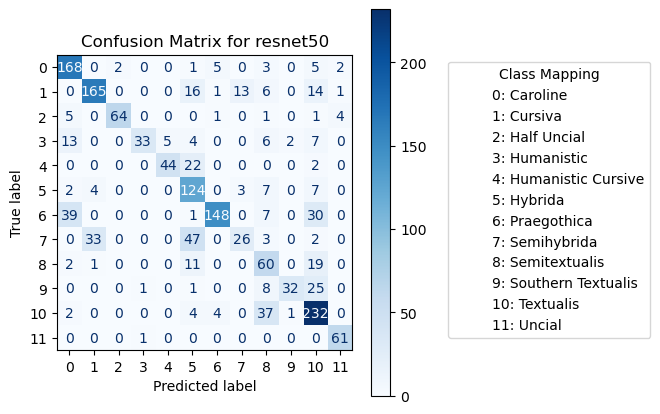




Tuned Precision: 0.7786383112338627
Tuned Recall: 0.7259987961174126
Tuned Specificity: 0.9765242679657758
Tuned Accuracy: 0.7520299812617114
Tuned F1: 0.7433639383016812
Tuned Top-1 Accuracy: 0.7520299812617114
Tuned Top-3 Accuracy: 0.9425359150530919
              precision    recall  f1-score   support

           0     0.7793    0.8925    0.8321       186
           1     0.7945    0.8056    0.8000       216
           2     0.9846    0.8421    0.9078        76
           3     0.8824    0.6429    0.7438        70
           4     0.8814    0.7647    0.8189        68
           5     0.6077    0.7483    0.6707       147
           6     0.9016    0.7333    0.8088       225
           7     0.5217    0.3243    0.4000       111
           8     0.5652    0.5591    0.5622        93
           9     0.8261    0.5672    0.6726        67
          10     0.6760    0.8643    0.7586       280
          11     0.9231    0.9677    0.9449        62

    accuracy                         0.7

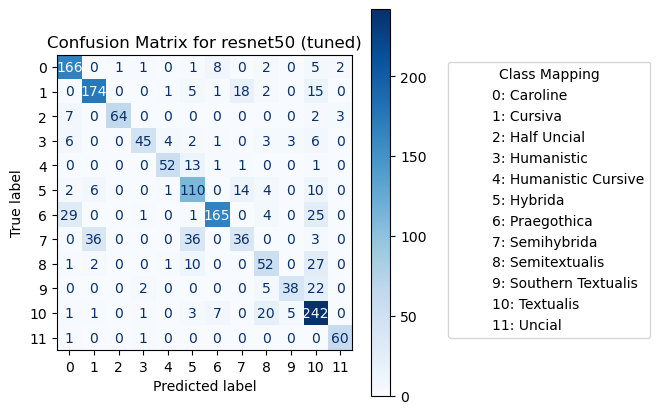





__________________________________________________

resnext101.pkl
__________________________________________________
Torch Precision: 0.8312378117981772
Torch Recall: 0.7524898546356974
Torch Specificity: 0.9787512817664399
Torch Accuracy: 0.7795128044971893
Torch F1: 0.7774907940784055
Torch Top-1 Accuracy: 0.7795128044971893
Torch Top-3 Accuracy: 0.9537788881948782
              precision    recall  f1-score   support

           0     0.8514    0.8011    0.8255       186
           1     0.7860    0.8333    0.8090       216
           2     0.9351    0.9474    0.9412        76
           3     0.8793    0.7286    0.7969        70
           4     1.0000    0.7794    0.8760        68
           5     0.6863    0.7143    0.7000       147
           6     0.8233    0.7867    0.8045       225
           7     0.6389    0.4144    0.5027       111
           8     0.8095    0.3656    0.5037        93
           9     0.9057    0.7164    0.8000        67
          10     0.6594    0.9

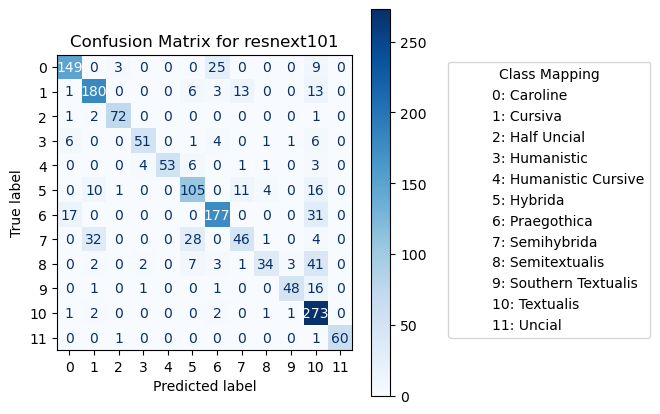




Tuned Precision: 0.8154034032435392
Tuned Recall: 0.7662802767446776
Tuned Specificity: 0.9794834645253171
Tuned Accuracy: 0.7851342910680824
Tuned F1: 0.7841392492942973
Tuned Top-1 Accuracy: 0.7851342910680824
Tuned Top-3 Accuracy: 0.9494066208619613
              precision    recall  f1-score   support

           0     0.8380    0.8065    0.8219       186
           1     0.8000    0.8333    0.8163       216
           2     0.9342    0.9342    0.9342        76
           3     0.8793    0.7286    0.7969        70
           4     0.9365    0.8676    0.9008        68
           5     0.6842    0.7075    0.6957       147
           6     0.7982    0.8089    0.8035       225
           7     0.6329    0.4505    0.5263       111
           8     0.6786    0.4086    0.5101        93
           9     0.8929    0.7463    0.8130        67
          10     0.7100    0.9357    0.8074       280
          11     1.0000    0.9677    0.9836        62

    accuracy                         0.7

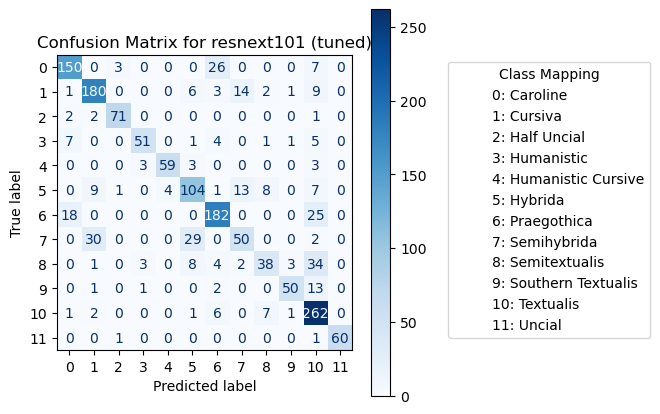





__________________________________________________

efficientnet_b0.pkl
__________________________________________________
Torch Precision: 0.7921238350112283
Torch Recall: 0.7709706025205388
Torch Specificity: 0.9795797607233854
Torch Accuracy: 0.7813866333541537
Torch F1: 0.774211558956205
Torch Top-1 Accuracy: 0.7813866333541537
Torch Top-3 Accuracy: 0.957526545908807
              precision    recall  f1-score   support

           0     0.8009    0.9086    0.8514       186
           1     0.7948    0.8426    0.8180       216
           2     1.0000    0.7368    0.8485        76
           3     0.8955    0.8571    0.8759        70
           4     0.8966    0.7647    0.8254        68
           5     0.6906    0.6531    0.6713       147
           6     0.8451    0.8489    0.8470       225
           7     0.7015    0.4234    0.5281       111
           8     0.4717    0.5376    0.5025        93
           9     0.6277    0.8806    0.7329        67
          10     0.7972    

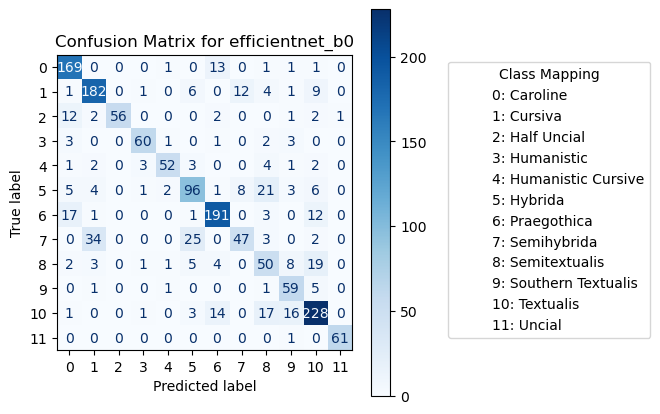




Tuned Precision: 0.7947542977729708
Tuned Recall: 0.7751878162920799
Tuned Specificity: 0.9800301893628066
Tuned Accuracy: 0.787632729544035
Tuned F1: 0.7814782308134075
Tuned Top-1 Accuracy: 0.787632729544035
Tuned Top-3 Accuracy: 0.9469081823860087
              precision    recall  f1-score   support

           0     0.8291    0.8871    0.8571       186
           1     0.7897    0.8519    0.8196       216
           2     0.9667    0.7632    0.8529        76
           3     0.8841    0.8714    0.8777        70
           4     0.8594    0.8088    0.8333        68
           5     0.6923    0.6735    0.6828       147
           6     0.8384    0.8533    0.8458       225
           7     0.6301    0.4144    0.5000       111
           8     0.5455    0.5161    0.5304        93
           9     0.7467    0.8358    0.7887        67
          10     0.7712    0.8429    0.8055       280
          11     0.9839    0.9839    0.9839        62

    accuracy                         0.787

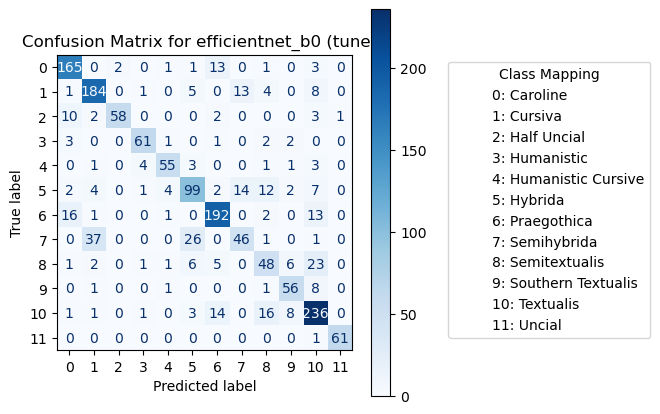





__________________________________________________

convnext_tiny.pkl
__________________________________________________
Torch Precision: 0.838541695069281
Torch Recall: 0.7994358073623067
Torch Specificity: 0.9827464049939153
Torch Accuracy: 0.8176139912554653
Torch F1: 0.8131319843481926
Torch Top-1 Accuracy: 0.8176139912554653
Torch Top-3 Accuracy: 0.9643972517176764
              precision    recall  f1-score   support

           0     0.8446    0.8763    0.8602       186
           1     0.8387    0.8426    0.8406       216
           2     0.9342    0.9342    0.9342        76
           3     0.9091    0.7143    0.8000        70
           4     0.8514    0.9265    0.8873        68
           5     0.7639    0.7483    0.7560       147
           6     0.9271    0.7911    0.8537       225
           7     0.5798    0.6216    0.6000       111
           8     0.7302    0.4946    0.5897        93
           9     0.9608    0.7313    0.8305        67
          10     0.7556    0

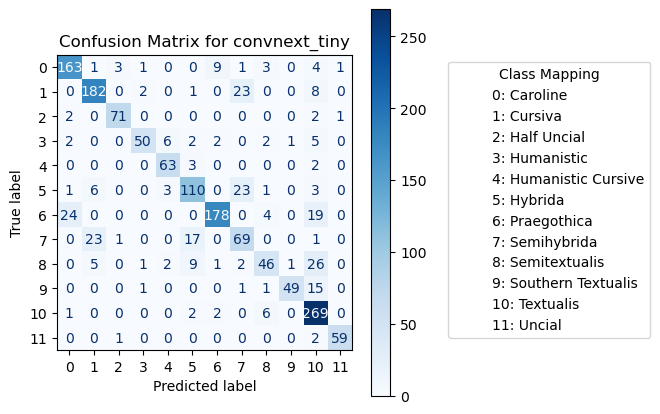




Tuned Precision: 0.8445624733014264
Tuned Recall: 0.8083488180766185
Tuned Specificity: 0.983584459389717
Tuned Accuracy: 0.8263585259212992
Tuned F1: 0.8227825132737161
Tuned Top-1 Accuracy: 0.8263585259212992
Tuned Top-3 Accuracy: 0.9631480324797002
              precision    recall  f1-score   support

           0     0.8526    0.8710    0.8617       186
           1     0.8273    0.8426    0.8349       216
           2     0.9467    0.9342    0.9404        76
           3     0.9153    0.7714    0.8372        70
           4     0.8732    0.9118    0.8921        68
           5     0.7785    0.7891    0.7838       147
           6     0.8657    0.8311    0.8481       225
           7     0.6075    0.5856    0.5963       111
           8     0.7101    0.5269    0.6049        93
           9     0.9608    0.7313    0.8305        67
          10     0.7970    0.9536    0.8683       280
          11     1.0000    0.9516    0.9752        62

    accuracy                         0.82

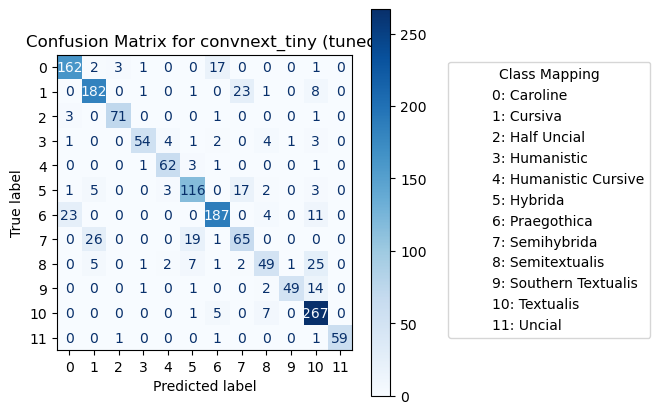





__________________________________________________

efficientnet_b0_noBLF_noGeo.pkl
__________________________________________________
Torch Precision: 0.8023366014521475
Torch Recall: 0.7868549583717082
Torch Specificity: 0.9809912192813406
Torch Accuracy: 0.7988757026858213
Torch F1: 0.787302023750143
Torch Top-1 Accuracy: 0.7988757026858213
Torch Top-3 Accuracy: 0.9662710805746408
              precision    recall  f1-score   support

           0     0.8556    0.8602    0.8579       186
           1     0.7671    0.8843    0.8215       216
           2     0.9857    0.9079    0.9452        76
           3     0.8182    0.9000    0.8571        70
           4     0.8906    0.8382    0.8636        68
           5     0.7518    0.7007    0.7254       147
           6     0.8750    0.8089    0.8406       225
           7     0.6304    0.5225    0.5714       111
           8     0.5952    0.2688    0.3704        93
           9     0.7500    0.8507    0.7972        67
          10  

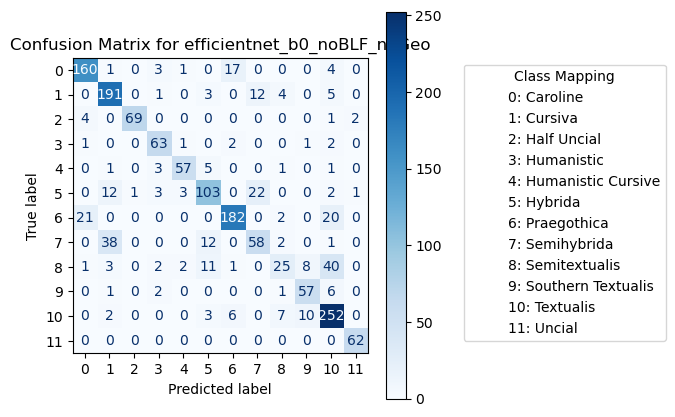




Tuned Precision: 0.8091127193264326
Tuned Recall: 0.790966334047905
Tuned Specificity: 0.9814345045311378
Tuned Accuracy: 0.8038725796377264
Tuned F1: 0.7956082566605764
Tuned Top-1 Accuracy: 0.8038725796377264
Tuned Top-3 Accuracy: 0.9656464709556527
              precision    recall  f1-score   support

           0     0.8602    0.8602    0.8602       186
           1     0.7983    0.8796    0.8370       216
           2     1.0000    0.9079    0.9517        76
           3     0.8378    0.8857    0.8611        70
           4     0.8806    0.8676    0.8741        68
           5     0.7698    0.7279    0.7483       147
           6     0.8605    0.8222    0.8409       225
           7     0.6556    0.5315    0.5871       111
           8     0.5660    0.3226    0.4110        93
           9     0.7826    0.8060    0.7941        67
          10     0.7448    0.8964    0.8136       280
          11     0.9531    0.9839    0.9683        62

    accuracy                         0.80

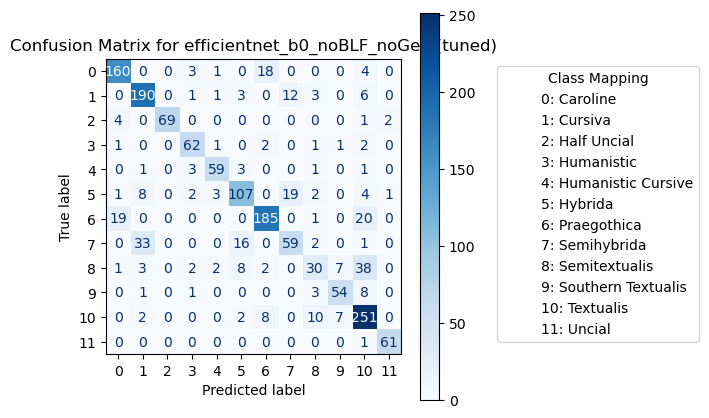





__________________________________________________

model_convnext_noBLF_noGeo.pkl
__________________________________________________
Torch Precision: 0.8274294547954918
Torch Recall: 0.8255701852048185
Torch Specificity: 0.9829883493660317
Torch Accuracy: 0.8188632104934416
Torch F1: 0.8251112320946233
Torch Top-1 Accuracy: 0.8188632104934416
Torch Top-3 Accuracy: 0.9656464709556527
              precision    recall  f1-score   support

           0     0.8564    0.8978    0.8766       186
           1     0.8558    0.8241    0.8396       216
           2     0.9733    0.9605    0.9669        76
           3     0.8630    0.9000    0.8811        70
           4     0.8788    0.8529    0.8657        68
           5     0.8154    0.7211    0.7653       147
           6     0.8985    0.7867    0.8389       225
           7     0.6055    0.5946    0.6000       111
           8     0.6484    0.6344    0.6413        93
           9     0.7692    0.8955    0.8276        67
          10  

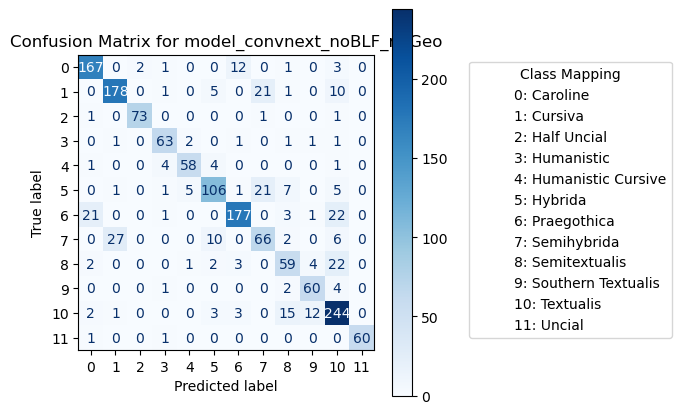




Tuned Precision: 0.8353245394840827
Tuned Recall: 0.8248223297159537
Tuned Specificity: 0.9830443934581012
Tuned Accuracy: 0.820737039350406
Tuned F1: 0.8290346938009127
Tuned Top-1 Accuracy: 0.820737039350406
Tuned Top-3 Accuracy: 0.9562773266708308
              precision    recall  f1-score   support

           0     0.8865    0.8817    0.8841       186
           1     0.8326    0.8287    0.8306       216
           2     0.9865    0.9605    0.9733        76
           3     0.8750    0.9000    0.8873        70
           4     0.8806    0.8676    0.8741        68
           5     0.7929    0.7551    0.7735       147
           6     0.8585    0.8089    0.8330       225
           7     0.6250    0.5405    0.5797       111
           8     0.6867    0.6129    0.6477        93
           9     0.8451    0.8955    0.8696        67
          10     0.7546    0.8786    0.8119       280
          11     1.0000    0.9677    0.9836        62

    accuracy                         0.820

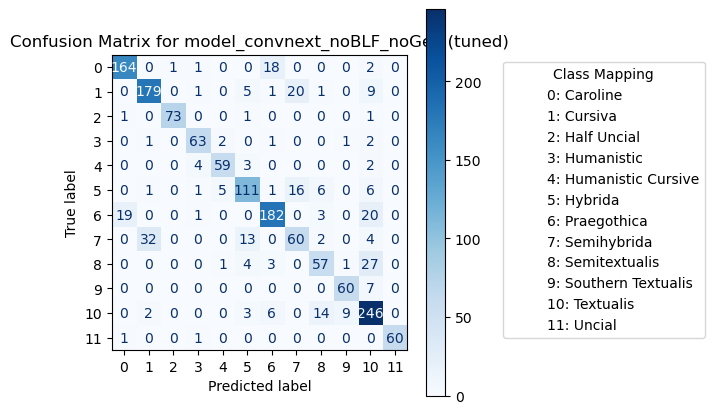

In [31]:
script_labels = [convert_to_script(c + 1) for c in range(12)]
metrics_dict = {}
for key,value in evaluation_results.items():
    metrics = score_models(evaluation_results[key],key)
    metrics_dict[key] = metrics

# score_models(evaluation_results['resnet50.pkl'],'resnet50.pkl')

In [32]:
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index')
metrics_df.index = metrics_df.index.str.replace('.pkl', '', regex=False)
metrics_df

metrics_df.to_csv("model_metrics.csv")